In [3]:
!pip install mat73
!pip install pyproj
!pip install svgpathtools
!pip install svgpath2mpl
!pip install netCDF4
!pip install cartopy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import matplotlib as mpl
import glob
import os
from matplotlib import cm
import matplotlib.dates as mdates
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import mat73
from pyproj import Proj
import matplotlib.pylab as pl
from scipy import signal
from os.path import dirname, join as pjoin
import scipy.io as sio
from svgpathtools import svg2paths
from svgpath2mpl import parse_path
from netCDF4 import Dataset, num2date
from pytz import timezone
import pytz
import missingno as msno
import re 
import mat73
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER



plt.style.use("default")
mpl.rcParams['xtick.labelsize']=12
mpl.rcParams['ytick.labelsize']=12
mpl.rcParams['font.sans-serif'] = "Century Gothic"
mpl.rcParams['font.family'] = "Century Gothic"
mpl.rcParams['font.weight'] = 'normal'
def fig_params(ax):
    ax.grid()    
    ax.spines['left'].set_color('gray')
    ax.spines['right'].set_color('gray')
    ax.spines['bottom'].set_color('gray')
    ax.spines['top'].set_color('gray')
    ax.tick_params('y', colors='tab:gray')
    ax.tick_params('x', colors='tab:gray')
    for label in ax.get_yticklabels():
        label.set_color('k')
        label.set_size(13)
    for label in ax.get_xticklabels():
        label.set_color('k')
        label.set_size(13)
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Funciones
def proj_ZONE17 (lon, lat):
    """
    Función para cambiar las proyecciones de las coordenadas:
    -----------------------------------------------------------
    Input:
    lon, lat
    ----------------------------------------------------------
    Output:
    UTMX, UTMY
    """
    myProj = Proj("+proj=utm +zone=17 +ellps=WGS84 +datum=WGS84")
    UTMx, UTMy = myProj(lon, lat)
    return UTMx,UTMy

def coord_wgs (UTMx,UTMy):
    """
    Función para cambiar georeferenciar las proyecciones:
    ----------------------------------------------------------
    Input:
    UTMX, UTMY
    ----------------------------------------------------------
    Output:
    lon, lat
    """
    myProj = Proj("+proj=utm +zone=17 +ellps=WGS84 +datum=WGS84")
    lon, lat = myProj(UTMx,UTMy, inverse = True)
    return 360 + lon, lat

def min_ind_rotated_grid (value1, vector1, value2, vector2, delta, view_coords:bool = None):
    """Función para encontrar la mínima diferencia entre dos celdas, usando una grilla de coordenadas 
    X y Y
    ---------------------------------------------------------------------
    Input: 
    - Value1: valor a encontrar de la coordenada x
    - Vector1: vectores donde quiere encontrar dicho valor en la malla X 
    - Value2: valor a encontrar de la coordenada y
    - Vector2: vectores donde quiere encontrar dicho valor en la malla Y 
    - delta: radio para encontrar ese valor 
    - view_coords: Boleano para imprimr las cordenadas reales y en la malla
    ----------------------------------------------------------------------
    Output: 
    - Indi: Indice correpondiente a la fila 
    - Indj: Indice correspondiente a la columna
    """
    indices = np.where(((vector1 > value1-(delta)) & (vector1 < value1+(delta))) & 
                        ((vector2 > value2-(delta)) & (vector2 < value2+(delta))))

    for i, j in zip(indices[0], indices[1]): 
        try :
            if( vector1[i, j] - value1 < vector1[i+1, j+1] - value1) & (vector2[i, j] - value2 < vector2[i+1, j+1] - value2):
                indi = i
                indj = j
            else:
                indi = i+1
                indj = j+1
        except:
            print('************error**********************')
    if view_coords == True:
        print(f'Indices: {indi}, {indj}')
        print(f'Valor 1: {vector1[indi, indj]}, Valor real 1: {value1}' )
        print(f'Valor 2: {vector2[indi, indj]}, Valor real 2: {value2}' )
    return indi, indj

In [3]:
def read_grid_file_d3d(num_btw_lines:int, ncols:int, nrows:int, path:str, name_file_grid:str, name_file_deep:str):
    """
    This function read the data from .grd file obtened of d3d
    --------------------------------------------------------------------
    Input:
    - num_btw_lines: cantidad de lineas entre cada eta
    - nrows: numéro de filas del archivo
    - ncols: numéro de columnas del archivo
    - path: ruta del archivo
    - name_file_grid:nombre del archivo
    --------------------------------------------------------------------
    Output: 
    - dic_ : diccionario donde cada llave es una fila y contine 
    las respectivas coordendas que deben ser iguales al numero de columnas 
    """
    patron_eta = r'\b\w+=\s*\d+'
    patron_num =  r'\d+\.\d+E[+-]?\d+'

    with open(f'{path}/{name_file_grid}', 'r') as f:
        contenido = f.read ()
    keys_dic = re.findall(patron_eta, contenido)

    with open(f'{path}/{name_file_grid}', 'r') as f:
        lineas = f.readlines()

    dic_ = {}
    for j, key in enumerate (keys_dic):
        list_ = []
        for i, linea in enumerate(lineas):
            eta = re.findall(patron_eta, linea)
            try:
                if  key == eta[0]:
                    nums_linea = re.findall(patron_num, linea)
                    for nu in nums_linea:
                        list_.append(float(nu))
                    for k in range (1, num_btw_lines):
                        nums_linea_plus = re.findall(patron_num, lineas[i+k])
                        for num in nums_linea_plus:
                            list_.append(float(num))             
            except: 
                pass
        arr= np.array(list_).reshape((ncols-1, 2), order = 'F') 
        dic_.update({key:pd.DataFrame({'X': arr[:,0], 'Y': arr[:,1]})})
    
    patron_num =  r'[-+]?\d+\.\d+E[+-]?\d+'
    with open(f'{path}/{name_file_deep}', 'r') as f:
        contenido = f.read ()
    deep = re.findall(patron_num, contenido)
    Z = []
    for z in deep:
        Z.append(float(z))
    Z = np.array(Z).reshape((nrows, ncols))
    Z[Z<0] = np.nan
    # Z = Z[:-1, :-1]


    X = np.zeros(shape = (nrows-1, ncols-1))
    Y = np.zeros(shape = (nrows-1, ncols-1))
    for i, key in enumerate(list(dic_.keys())):
        X[i, :] = dic_[key]['X']
        Y[i, :] = dic_[key]['Y']

    return X,Y, Z

def read_coast_line (path:str, name_file:str):
    """
    Esta función lee los datos de la linea de costa de un archivo .mat (v6)
    -------------------------------------------------------------------------
    Input:
    - path: ruta del archivo
    - name_file: nombre del archivo
    -------------------------------------------------------------------------
    Output:
    - Data Frame de la linea dosta
    """
    data_dir = pjoin(dirname(sio.__file__), path) # Definir Ruta
    mat_fname = pjoin(data_dir, name_file)     # Econtrar el archivo
    data_mat = sio.loadmat(mat_fname)                 # Cargar el archivo
    xlc, ylc = np.array(data_mat['data'][0][0][0]), np.array(data_mat['data'][0][0][1])
    lc  = np.column_stack((xlc,ylc))
    df_lc = pd.DataFrame({'X':lc[:,0], 'Y':lc[:,1] })
    return df_lc

def bat_figure(df_lc:pd.DataFrame, X:np.array, Y:np.array, Z:np.array,delta_lim:float ,delta:float, active_puntos_obs: bool,size:tuple = (7, 5.5), df_ind = None, bottom_legend = None):
    """Función para graficar la malla orientada
    -------------------------------------------------------------------------------------------------
    Input: 
    - df_lc: linea de costa
    - X: arreglo en dos o una dimensión de la malla (dirección x)
    - Y: arreglo en dos o una dimensión de la malla (dirección y)
    - Z: arreglo de las profundidades, las dimesiones deben corresponder con las dimensiones de X y Y
    - size: tupla de las dimensiones de la figura
    - delta: delta para ubicar el norte respecto a la esquina superior derecha (se resta)
    - delta_lim: limites de la figura
    -------------------------------------------------------------------------------------------------
    Output:
    - Figure 

    """

    fig, ax = plt.subplots(figsize = size)
    colormap = cm.Blues
    levels = list(np.round(np.nanmax(Z)*np.array([0,1, 5, 10, 15, 20, 25, 50, 75, 100])/100,0))
    pc = ax.contourf(X, Y, Z,levels = levels,cmap=colormap)
    cb=plt.colorbar(pc)
    a = ax.contour(X, Y, Z,colors="gray",levels=levels,\
                    linewidths=0.2)
    labels = plt.clabel(a, fontsize=8, inline=1, fmt = '%1.0f', colors="gray")
    ax.set_xlabel ('E [m]',size=13, fontweight = 'semibold')
    ax.set_ylabel ('N [m]',size=13, fontweight = 'semibold')
    if (X.min() < df_lc['X'].min()) | (Y.min() < df_lc['Y'].min()):
            ax.set_xlim([X.min() - delta_lim, X.max() + delta_lim])
            ax.set_ylim([Y.min()- delta_lim, Y.max() + delta_lim])
    else:
        ax.set_xlim([df_lc['X'].min(), X.max() + delta_lim])
        ax.set_ylim([df_lc['Y'].min(), Y.max() - delta_lim])
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    cb.set_label('Depth [m]',size=13, fontweight = 'semibold')
    cb.set_ticklabels(cb.get_ticks(),size=10)
    fig_params(ax)
    fig.suptitle("Bathymetry", size = 13, fontweight = 'semibold')     # Titulo de la figura
    ax.set_title('San Andrés Island',size = 13, fontweight = 'semibold')   # Subtítulo de la figura
    ax.plot(df_lc['X'], df_lc['Y'], "-",c='chocolate', lw=2.5, alpha = 1)
    ax.fill_between(df_lc['X'], df_lc['Y'], color='chocolate', alpha=0.5, linewidth=0)

    try:
      brujula_path, attributes = svg2paths('/content/drive/MyDrive/TESIS_MAESTRIA_PAULAE/MODELO_NUMERICO/BASES_DE_DATOS/CLIMATOLOGIA_HYCOM/Scripts/brujula.svg')
    except: 
      brujula_path, attributes = svg2paths('brujula.svg')
    brujula_marker = parse_path(attributes[0]['d'])
    brujula_marker.vertices -= brujula_marker.vertices.mean(axis=0)
    brujula_marker = brujula_marker.transformed(mpl.transforms.Affine2D().rotate_deg(0))
    brujula_marker = brujula_marker.transformed(mpl.transforms.Affine2D().scale(-1,1))
    ax.scatter(X.max()-delta, Y.max()-delta, marker= brujula_marker, color = 'k', s = 8**3)

    if active_puntos_obs == True:
        colors = mpl.cm.jet_r(np.linspace(0,1,len(df_ind)))
        k = 0
        for col, row in zip (df_ind['Ind_X'], df_ind['Ind_Y']):
            ax.scatter(X[row, col], Y[row, col], marker = '+', color = colors[k], label = df_ind['ID'][k], s = 8**2, lw = 2)
            k = k+1
        _= ax.legend(loc='upper center', bbox_to_anchor=(0.5, bottom_legend),
                fancybox=True, shadow=True, ncol=4, fontsize = 9)


    fig.tight_layout()
    plt.xticks(rotation = 20)
    plt.grid(False)



def df_project_grid_grid(n_cols, n_rows, X, Y):
    """
    df_project_grid_grid
    ======================================================================
    ----------------------------------------------------------------------
    Esta función entrega las coordenadas de las fronteras de la batimetría
    ----------------------------------------------------------------------
    Input:
    -----
    - n_cols: número de columnas que se muestran en delft
    - n_rows: número de filas que se muestran en delft
    - X: Arreglo de coordenadas en dirección X 
    - Y: Arreglo de coordenadas en dirección Y
    ----------------------------------------------------------------------
    Output:
    -------
    - df_bat: Dataframe de las coordendas de las fronteras de la malla
    """
    df_bat = pd.concat([pd.DataFrame({'X':X[:,0], 'Y':Y[:,0]}),
                    pd.DataFrame({'X':[np.nan], 'Y':[np.nan]}),
                    pd.DataFrame({'X':X[:,n_cols-2], 'Y':Y[:,n_cols-2]}),
                    pd.DataFrame({'X':[np.nan], 'Y':[np.nan]}), 
                    pd.DataFrame({'X':X[0,:], 'Y':Y[0,:]}),
                    pd.DataFrame({'X':[np.nan], 'Y':[np.nan]}), 
                    pd.DataFrame({'X':X[n_rows-2,:], 'Y':Y[n_rows-2,:]}),
                    pd.DataFrame({'X':[np.nan], 'Y':[np.nan]})]).reset_index(drop=True)
    
    fun_coords = lambda x: coord_wgs(df_bat.iloc[x,0], df_bat.iloc[x,1])
    coords_bat = list(map(fun_coords, df_bat.index))
    df_bat['lon'] = list(map(lambda x: coords_bat[x][0], df_bat.index))
    df_bat['lat'] = list(map(lambda x: coords_bat[x][1], df_bat.index))

    return df_bat



# Read Hycom Data

In [4]:
def read_hycom_data(path):
    data = Dataset(f'{path}', 'r')
    try: 
        lat = np.array(data.variables['latitude'][:])
        lon = np.array(data.variables['longitude'][:])
    except: 
        lat = np.array(data.variables['lat'][:])
        lon = np.array(data.variables['lon'][:])
    nctime = np.array(data.variables['time'][:])
    t_unit = data.variables['time'].units
    t_cal = data.variables['time'].calendar
    time = num2date(nctime,units=t_unit,calendar=t_cal)#Date time
    time_str = np.array([time[i].strftime("%Y-%m-%d %H:%M:%S") for i in range (len(time))])
    time = np.array([datetime.datetime.strptime(time_str[i], "%Y-%m-%d %H:%M:%S") for i in range (len(time))])
    # ______Cambiar la zona horaria utc 0 a utc -5________________
    utc = pytz.utc
    # col_zone = timezone('America/Bogota')
    col_zone = timezone('GMT')
    time2=np.array([datetime.datetime(i.year,i.month,i.day,i.hour,i.minute,tzinfo=utc) for i in time])
    loc_co =np.array([i.astimezone(col_zone) for i in time2])
    time = np.array([datetime.datetime(i.year,i.month,i.day,i.hour,i.minute) for i in loc_co])

    salt = np.array(data.variables['salinity'][:]).astype(float)
    salt[salt<=-30000] = np.nan
    temp = np.array(data.variables['water_temp'][:]).astype(float)
    temp[temp<=-30000] = np.nan
    depth = np.array(data.variables['depth'][:]) 

    dic_ = {'time':time,'lat': lat, 'lon': lon,'depth': depth,  'salt': salt, 'temp': temp }
    return dic_



def min_ind (value, vector, delta):
    """Función para encontrar la mínima diferencia entre dos celdas
    Input: 
    - Value: valor a encontrar 
    - Vector: vectores donde quiere encontrar dicho valor
    - delta: radio para encontrar ese valor 
    ----------------------------------------------------------------------
    Output: 
    - Ind: indices donde mayor se aproxima el valor buscado a los vectores
    """
    indices = np.where((vector > value-(delta)) & (vector < value+(delta)))[0]
    for i in indices: 
        try :
            if vector[i] - value < vector[i+1] - value:
                ind = i
            else:
                ind = i+1
        except:
            print('**********ERROR************')
    
    print('Indice:',ind,', Valor:', vector[ind], ', Valor real:', value)
    return ind


In [5]:
def plot_cells_data_base (lon:np.array, lat:np.array, plot_dfbat:bool, df_bat: pd.DataFrame = None):
    """
    Esta función plotea los centros de las celdas donde hay información de la base de datos
    -----------------------------------------------------------------------------------------
    Input:
    ------
    - lon: arreglo de las longitudes de los datos obtenidos de la base de datos
    - lat:  arreglo de las latitudes de los datos obtenidos de la base de datos
    - plot_df_bat: True/ False: para plotear o no la ubicación de la malla con respecto a la base de datos 
    ------------------------------------------------------------------------------------------------------
    Output: 
    -------
    - Figure
    """ 

    fig = plt.figure(figsize = (10,5))
    ax1 = fig.add_subplot(projection = ccrs.PlateCarree())
    ax1.set_extent([np.min(lon)-0.1,np.max(lon)+0.1, np.min(lat)-0.1, np.max(lat)+0.1])

    gl = ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
    ax1.stock_img()
    ax1.add_feature(cf.LAND, zorder= 10)
    ax1.add_feature(cf.COASTLINE, lw=3, color= 'tan', zorder = 11 )
    # ax1.add_feature(cf.RIVERS, lw = 2)
    ax1.add_feature(cf.BORDERS, lw = 3, color = 'tan')


    colors_cm = pl.cm.jet(np.linspace(0,1, len(lon)*len(lat)))
    i = 0
    for loni in (lon):
        for lati in (lat):
            ax1.scatter(loni, lati, marker = 'o', s = 10, label = 'Cords '+str(lati)+'-'+str(loni), color = colors_cm[i])
            i = i +1

    if plot_dfbat == True: 
        ax1.scatter(df_bat['lon'], df_bat['lat'],color = 'red', s=1)
    ax1.set_yticklabels(ax1.get_yticks() , color='gray',size = 12)
    ax1.set_xticklabels(ax1.get_xticks() , color='gray',size = 12)
    ax1.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax1.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax1.tick_params('y', colors='tab:gray')
    ax1.tick_params('x', colors='tab:gray')




    #------------ Labels de cartopy--------------- 
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.ylabel_style = {'size': 10, 'color': 'gray','weight': 'bold' }
    gl.xlabel_style = {'size': 10, 'color': 'gray', 'weight': 'bold' }


    ax1.spines['left'].set_color('gray')
    ax1.spines['right'].set_color('gray')
    ax1.spines['bottom'].set_color('gray')
    ax1.spines['top'].set_color('gray')

    # _= fig.legend(loc='upper center', bbox_to_anchor=(0.85, 0.9),
    #           fancybox=True, shadow=True, ncol=2, fontsize = 8,prop=prop2, labelcolor = 'gray')
    fig.suptitle('Localización de los pixeles',size=12);
    fig.tight_layout()
    plt.subplots_adjust(wspace=0.3)
    plt.subplots_adjust(hspace=0.25)

# Climatología

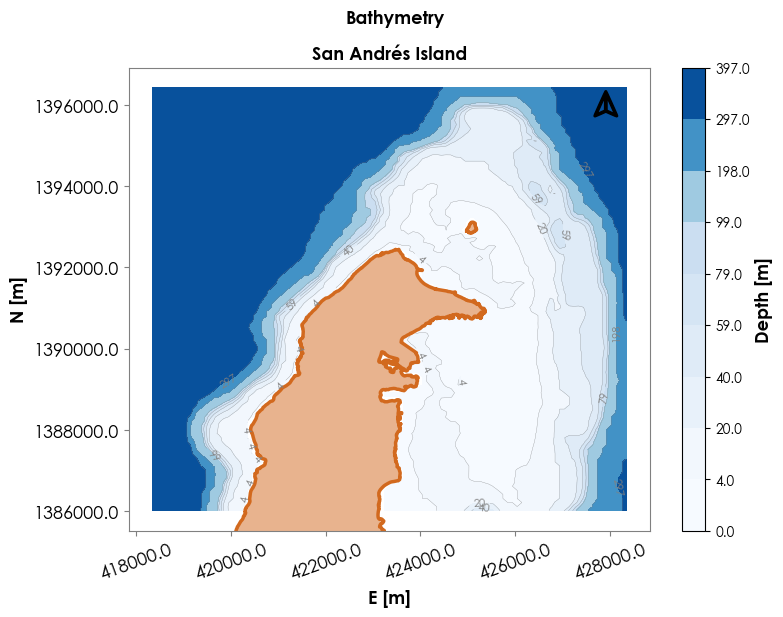

In [6]:
# path = r"/content/drive/MyDrive/TESIS_MAESTRIA_PAULAE/MODELO_NUMERICO/BATIMETRIA/BAT_NORTE_RECTANGULAR_100m"
path = r'G:\My Drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\BATIMETRIA\BAT_NORTE_RECTANGULAR_100m'
# path = r'C:\Users\paula\Desktop\BAT_SAI_NORTE_3D_V2'
name_file_grid = 'BAT_SAI_NORTE.grd'
name_file_deep = 'BAT_SAI_NORTE.dep'
name_file_coast = 'COAST_LINE.mat'

# num_lineas = 31
# n_rows = 238 #83
# n_cols = 155

num_lineas = 21
n_rows = 106 #83
n_cols = 102

df_lc = read_coast_line (path= path, name_file = name_file_coast)
X, Y, Z = read_grid_file_d3d(num_btw_lines = num_lineas, ncols = n_cols, 
                             nrows = n_rows, path = path, name_file_grid = name_file_grid, name_file_deep = name_file_deep)
df_bat_sai = df_project_grid_grid(n_cols = n_cols, n_rows = n_rows, X= X, Y = Y)
bat_figure(df_lc= df_lc,X= X, Y= Y, Z=Z[:-1,:-1], delta_lim= 500,delta = 450 ,size = (8, 6), active_puntos_obs = False)

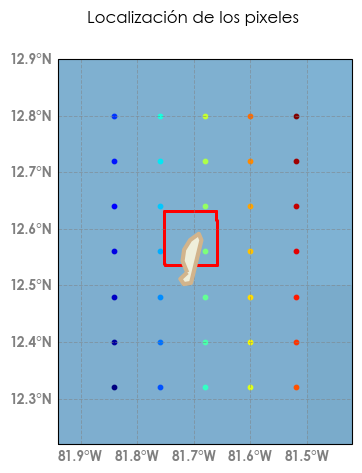

In [7]:
path = r'G:\My Drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\BASES_DE_DATOS\CLIMATOLOGIA_HYCOM\Scripts'
name_file = "hycom_prueba.nc"
dic_prop = read_hycom_data(path = f'{path}\{name_file}')
lat = dic_prop['lat']
lon = dic_prop['lon']
plot_cells_data_base (lon = lon, lat = lat, plot_dfbat = True, df_bat = df_bat_sai)

In [8]:
dic_prop['time']

array([datetime.datetime(2012, 3, 1, 0, 0),
       datetime.datetime(2012, 3, 1, 6, 0),
       datetime.datetime(2012, 3, 1, 12, 0),
       datetime.datetime(2012, 3, 1, 18, 0),
       datetime.datetime(2012, 3, 2, 0, 0),
       datetime.datetime(2012, 3, 2, 6, 0),
       datetime.datetime(2012, 3, 2, 12, 0),
       datetime.datetime(2012, 3, 2, 18, 0),
       datetime.datetime(2012, 3, 3, 0, 0),
       datetime.datetime(2012, 3, 3, 6, 0),
       datetime.datetime(2012, 3, 3, 15, 0),
       datetime.datetime(2012, 3, 3, 21, 0),
       datetime.datetime(2012, 3, 4, 3, 0),
       datetime.datetime(2012, 3, 4, 9, 0),
       datetime.datetime(2012, 3, 4, 15, 0),
       datetime.datetime(2012, 3, 4, 21, 0),
       datetime.datetime(2012, 3, 5, 3, 0),
       datetime.datetime(2012, 3, 5, 9, 0),
       datetime.datetime(2012, 3, 5, 15, 0),
       datetime.datetime(2012, 3, 5, 21, 0),
       datetime.datetime(2012, 3, 6, 3, 0),
       datetime.datetime(2012, 3, 6, 9, 0),
       datetime.dateti

In [ ]:
paths_aw600 = glob.glob(r"G:\My drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\DATOS_CAMPO\DATOS_SAI_4_15_nov_2021\AWAC600\*.nc")
paths_aw600 = sorted(paths_aw600)